In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys
sys.path.append('../')
from plancklens import utils

In [3]:
%load_ext autoreload
%autoreload 2
from dance.filtering import WienerFilter
from dance.qe import Reconstruct
from dance.delens import Delens

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
basedir = '/mnt/sdceph/users/alonappan/DANCE'

In [5]:
recon_aniso = Reconstruct(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="a_p")

CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file


/mnt/home/alonappan/anaconda3/cstm_pkgs/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


alm2lenmap_spin: using 48 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:53.177719] (47.4%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:01.971769] (1.8%)  
  build_angles                         :  [0:00:55.149547] (49.1%)  
  synthesis general (STANDARD)         :  [0:00:56.529935] (50.4%)  
  polrot (ducc)                        :  [0:00:00.338166] (0.3%)  
  gclm2lenmap                          :  [0:01:52.229029] (100.0%)  
  Total                                :  [0:01:52.231109] d:h:m:s:mus


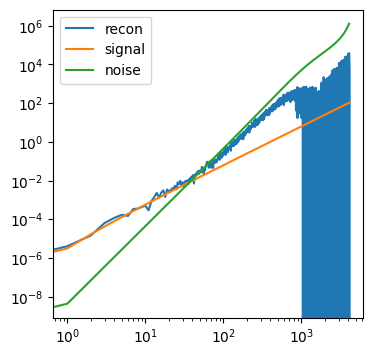

In [16]:
recon_aniso.plot_qcl(1,which='recon')

In [17]:
recon_aniso_kappa = Reconstruct(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="p_p")

CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
/mnt/home/alonappan/anaconda3/cstm_pkgs/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


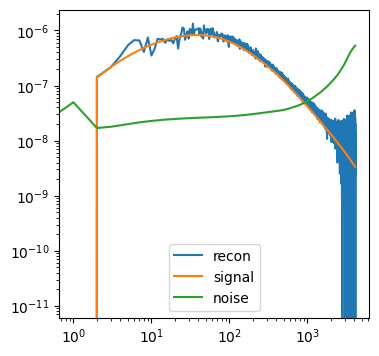

In [18]:
recon_aniso_kappa.plot_qcl(1,which='recon')

In [19]:
delens = Delens(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="p_p",lmin_delens=50,lmax_delens=4096)

CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file


CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file


In [22]:
delens.delens(1)

/mnt/home/alonappan/anaconda3/cstm_pkgs/plancklens/plancklens/utils.py:124: RuntimeWarning: overflow encountered in cast
  return hashlib.sha1(np.copy(cl.astype(dtype), order='C')).hexdigest()


alm2lenmap_spin: using 48 nthreads
  build angles <- synthesis (GRAD_ONLY):  [0:00:21.884409] (49.0%)  
  build angles <- th-phi-gm (ducc)     :  [0:00:01.956037] (4.4%)  
  build_angles                         :  [0:00:23.840485] (53.4%)  
  synthesis general (STANDARD)         :  [0:00:20.366795] (45.6%)  
  polrot (ducc)                        :  [0:00:00.348129] (0.8%)  
  gclm2lenmap                          :  [0:00:44.650614] (100.0%)  
  Total                                :  [0:00:44.651739] d:h:m:s:mus


[array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        2.62831643e-03+0.00000000e+00j, ...,
        5.30026818e-07+1.29801934e-06j, 5.56711999e-07-1.54009137e-06j,
        2.85473423e-07+1.32920157e-06j]),
 array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        -5.91063333e-04+0.00000000e+00j, ...,
         2.10995742e-07+2.68277347e-07j,  5.29371064e-07+4.98433494e-07j,
        -8.93179451e-08+4.56046736e-07j])]

In [23]:
recon_delens = Reconstruct(basedir,2048,1,True,"aniso",Acb=1e-6,lmin_ivf=2,lmax_ivf=4096,lmax_qlm=4096,qe_key="a_p",delens=delens)

CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file
CMB : INFO - Anisotropic cosmic birefringence model selected
CMB : INFO - Loading CMB power spectra from file


Delens Filtering


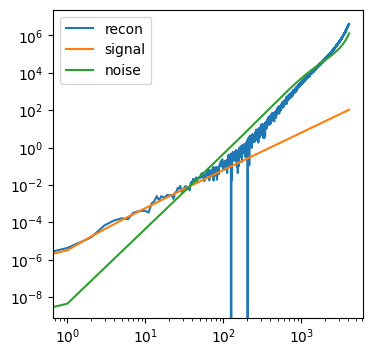

In [25]:
recon_delens.plot_qcl(1,which='recon')